# DES Simulation

This notebook generates the results used in the report for the second assignment of the course 'Stochastic Simulation'.

Authors:

1. Divyaben Hasmukhbhai Gajera
- Affiliation: MSc Computational Science, University of Amsterdam
- Email: divya.gajera@student.uva.nl
- Student Number: 14932644

2. K. López
- Affiliation: MSc Computational Science, University of Amsterdam
- Email: kenia.lopez.sotomayor@student.uva.nl
- Student Number: 12965081

3. T. P. Glansdorp
- Affiliation: MSc Computational Science, University of Amsterdam
- Email: thomas.glansdorp@student.uva.nl
- Student Number: 12748587

## DES program that implements FIFO scheduling case

In [ ]:
!pip install simpy

In [80]:
import simpy as sm
import random
import pandas as pd
import csv
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt

In [81]:
class g:
    arrival_rate = 1
    service_rate = 2
    number_of_servers = 1
    sim_duration = 200
    number_of_runs = 100

class Customer:
    def __init__(self, customer_id):
        self.id = customer_id
        self.queue_time = 0

class Queue:
    
    def __init__(self, run_number, queue_type):
        self.env = sm.Environment()
        self.server = sm.Resource(self.env, capacity=g.number_of_servers)
        self.queue_type = queue_type
        self.customer_counter = 0
        self.mean_queue_time = 0
        self.mean_sojourn_time = 0
        columns = ["Customer ID", "Start Queueing", "End Queueing", "Queueing Time", "Sojourn Time"] 
        self.results_df = pd.DataFrame(columns=columns)
        self.results_df.set_index("Customer ID", inplace=True)
        self.arrival_times = []
        self.departure_times = []
        
    
    # Method that generates customers arrivals
    def generate_arrivals(self):
        while True:
            self.customer_counter += 1
            cp = Customer(self.customer_counter)
            # Run activity generator for this customer
            self.env.process(self.create_queue(cp))

            # sample time until next customer
            t = random.expovariate(g.arrival_rate)

            # Freeze untill that time has passed
            yield self.env.timeout(t)
            
    def create_queue(self, customer):
        start_queue = self.env.now
        self.arrival_times.append(self.env.now)
        
        # Request a server
        with self.server.request() as req:
            # Freeze until the request can be met 
            yield req
            
            # Sample time spent in server
            if self.queue_type == "MMn":
                sampled_service_time = random.expovariate(g.service_rate)
            elif self.queue_type == "MDn":
                sampled_service_time = 0.5
            elif self.queue_type == "MLn":
                    rand = random.random()
                    if rand <= 0.75:
                        sampled_service_time = random.expovariate(1.0)
                    else:
                        sampled_service_time = random.expovariate(5.0)
            
            end_queue = self.env.now
            
            # Freeze until that time has passed
            yield self.env.timeout(sampled_service_time)
            self.departure_times.append(self.env.now)
            
            # Calculate time customer was queueing
            out_of_system = self.env.now
            sojourn_time = out_of_system - start_queue
            customer.queue_time = end_queue - start_queue
            
            df_to_add = [start_queue, end_queue, customer.queue_time, sojourn_time]
            self.results_df.loc[customer.id] = df_to_add
            
    def calculate_mean_times(self):
        self.mean_queue_time = self.results_df["Queueing Time"].mean()
        self.mean_sojourn_time = self.results_df["Sojourn Time"].mean()
            
    def run(self):
        self.env.process(self.generate_arrivals())
        self.env.run(until=g.sim_duration)
        # Calculate run results
        self.calculate_mean_times()
        

In [3]:
def calculate_CI(data):
    
    sigma = data.std()
    x_bar = data.mean()
    CI = (x_bar - (1.96*sigma/np.sqrt(data.shape[0])), x_bar + (1.96*sigma/np.sqrt(data.shape[0])))
    
    return CI

In [4]:
def estimate_waiting_times(type_queue, RHO, n, sim_dura):
    
    MU = 1
    mean_queue = []
    mean_sojourn = []
    
    for rho in RHO:
        temp_mean_queue_run = []
        temp_sj = []
        g.arrival_rate = MU*rho
        g.service_rate = MU
        g.number_of_servers = n
        g.number_of_runs = 100
        g.sim_duration = sim_dura
        for run in range(g.number_of_runs):
            if type_queue == "SJF":
                queue_model = SJF_queue()
            else:
                queue_model = Queue(run, type_queue)
            queue_model.run()
            temp_mean_queue_run.append(queue_model.mean_queue_time)
            temp_sj.append(queue_model.mean_sojourn_time)
        mean_queue.append(np.array(temp_mean_queue_run).mean(axis=0))
        mean_sojourn.append(np.array(temp_sj).mean(axis = 0))
        
    return mean_queue, mean_sojourn

### Shortest Job First

In [99]:
class SJF_queue:
    
    def __init__(self, run_number, queue_type):
        self.env = sm.Environment()
        self.server = sm.PriorityResource(self.env, capacity=g.number_of_servers)
        self.customer_counter = 0
        self.mean_queue_time = 0
        self.mean_sojourn_time = 0
        columns = ["Customer ID", "Start Queueing", "End Queueing", "Queueing Time", "Sojourn Time"] 
        self.results_df = pd.DataFrame(columns=columns)
        self.results_df.set_index("Customer ID", inplace=True)
        self.arrival_times = []
        self.departure_times = []
        self.queue_type = queue_type
        self.run_number = run_number
    
    # Method that generates customers arrivals
    def generate_arrivals(self):
        while True:
            self.customer_counter += 1
            cp = Customer(self.customer_counter)
            # Run activity generator for this customer
            self.env.process(self.create_queue(cp))

            # sample time until next customer
            t = random.expovariate(g.arrival_rate)

            # Freezr untill that time has passed
            yield self.env.timeout(t)
            
    def create_queue(self, customer):
        start_queue = self.env.now
        self.arrival_times.append(self.env.now)

        # Request a server
        sampled_service_time = random.expovariate(g.service_rate)
        with self.server.request(priority = (sampled_service_time)) as req:
            # Freeze until the request can be met 
            yield req  
            
            if self.queue_type == "MMn":
                sampled_service_time = random.expovariate(g.service_rate)
            elif self.queue_type == "MDn":
                sampled_service_time = 2
            elif self.queue_type == "MLn":
                    rand = random.random()
                    if rand <= 0.75:
                        sampled_service_time = random.expovariate(1.0)
                    else:
                        sampled_service_time = random.expovariate(5.0)

            end_queue = self.env.now

            # Freeze until that time has passed
            yield self.env.timeout(sampled_service_time)
            self.departure_times.append(self.env.now)
            
            # Calculate time customer was queueing
            out_of_system = self.env.now
            sojourn_time = out_of_system - start_queue
            customer.queue_time = end_queue - start_queue
            df_to_add = [start_queue, end_queue, customer.queue_time, sojourn_time]
            self.results_df.loc[customer.id] = df_to_add
            
    def calculate_mean_queue_time(self):
        self.mean_queue_time = self.results_df["Queueing Time"].mean()
        self.mean_sojourn_time = self.results_df["Sojourn Time"].mean()
        
    def run(self):
        self.env.process(self.generate_arrivals())
        self.env.run(until=g.sim_duration)
        # Calculate run results
        self.calculate_mean_queue_time()
        #self.write_run_results() 

### Analysis 

In [5]:
RHO = [0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]

In [7]:
est_mean_MMn1, est_sojourn_MMn1 = estimate_waiting_times("MMn", RHO, 1, 300)
est_mean_MMn2, est_sojourn_MMn2 = estimate_waiting_times("MMn", RHO, 2, 300)
est_mean_MMn4, est_sojourn_MMn4 = estimate_waiting_times("MMn", RHO, 4, 300)

In [8]:
est_mean_MDn1, est_sojourn_MDn1 = estimate_waiting_times("MDn", RHO, 1, 300)
est_mean_MDn2, est_sojourn_MDn2 = estimate_waiting_times("MDn", RHO, 2, 300)
est_mean_MDn4, est_sojourn_MDn4 = estimate_waiting_times("MDn", RHO, 4, 300)

In [9]:
est_mean_MLn1, est_sojourn_MLn1 = estimate_waiting_times("MLn", RHO, 1, 300)
est_mean_MLn2, est_sojourn_MLn2 = estimate_waiting_times("MLn", RHO, 2, 300)
est_mean_MLn4, est_sojourn_MLn4 = estimate_waiting_times("MLn", RHO, 4, 300)

In [12]:
est_mean_SJF_1, est_sojourn_SJF_1 = estimate_waiting_times("SJF", RHO, 1, 300)
est_mean_SJF_2, est_sojourn_SJF_2 = estimate_waiting_times("SJF", RHO, 2, 300)
est_mean_SJF_4, est_sojourn_SJF_4 = estimate_waiting_times("SJF", RHO, 4, 300)

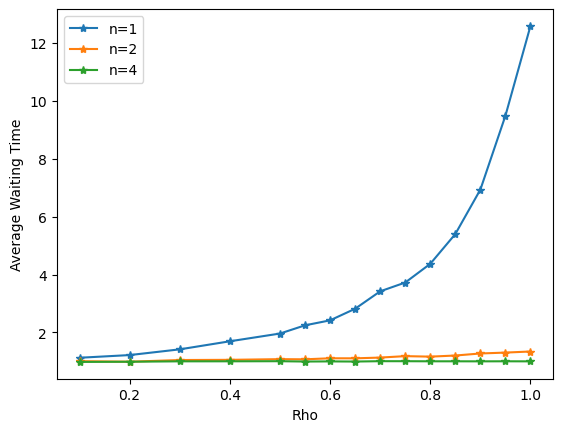

In [56]:
plt.plot(RHO, est_sojourn_MMn1, "*-", label = "n=1")
plt.plot(RHO, est_sojourn_MMn2, "*-", label = "n=2")
plt.plot(RHO, est_sojourn_MMn4, "*-", label = "n=4")
plt.legend()
plt.xlabel("Rho", fontsize = 10)
plt.ylabel("Average Waiting Time", fontsize= 10)
plt.savefig("W_Vs_Rho_MMn.jpeg")
plt.savefig("W_Vs_Rho_MMn.svg")

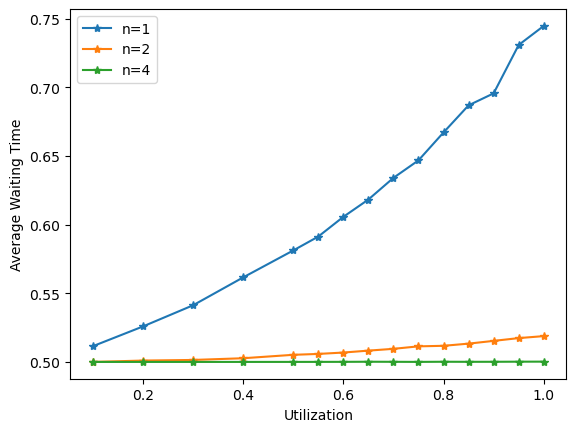

In [55]:
plt.plot(RHO, est_sojourn_MDn1, "*-", label = "n=1")
plt.plot(RHO, est_sojourn_MDn2, "*-", label = "n=2")
plt.plot(RHO, est_sojourn_MDn4, "*-", label = "n=4")
plt.legend()
plt.xlabel("Utilization", fontsize = 10)
plt.ylabel("Average Waiting Time", fontsize= 10)
plt.savefig("W_Vs_Rho_MDn.jpeg")
plt.savefig("W_Vs_Rho_MDn.svg")

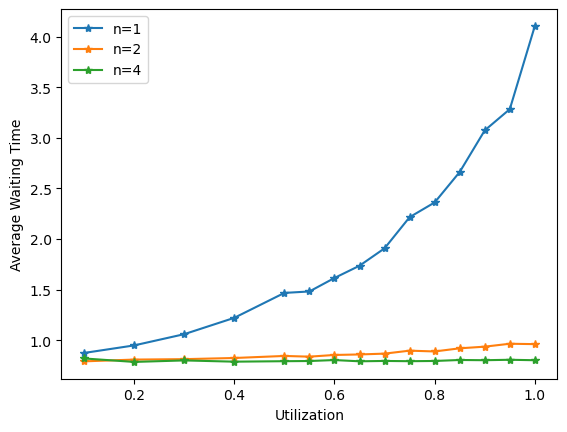

In [54]:
plt.plot(RHO, est_sojourn_MLn1, "*-", label = "n=1")
plt.plot(RHO, est_sojourn_MLn2, "*-", label = "n=2")
plt.plot(RHO, est_sojourn_MLn4, "*-", label = "n=4")
plt.legend()
plt.xlabel("Utilization", fontsize = 10)
plt.ylabel("Average Waiting Time", fontsize= 10)
plt.savefig("W_Vs_Rho_MLn.jpeg")
plt.savefig("W_Vs_Rho_MLn.svg")

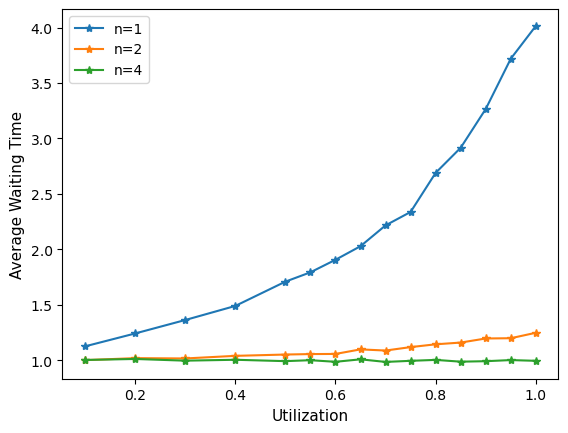

In [53]:
plt.plot(RHO, est_sojourn_SJF_1, "*-", label = "n=1")
plt.plot(RHO, est_sojourn_SJF_2, "*-", label = "n=2")
plt.plot(RHO, est_sojourn_SJF_4, "*-", label = "n=4")
plt.legend()
plt.xlabel("Utilization", fontsize = 11)
plt.ylabel("Average Waiting Time", fontsize= 11)
plt.savefig("W_Vs_Rho_SJF.jpeg")
plt.savefig("W_Vs_Rho_SJF.svg")

### Analysis of waiting time Vs Simulation Duration

In [17]:
Rho = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]

In [19]:
est_mean_20, est_sojourn_20 = estimate_waiting_times("MMn", Rho, 1, 20)

In [43]:
est_mean_50, est_sojourn_50 = estimate_waiting_times("MMn", Rho, 1, 50)

In [21]:
est_mean_100, est_sojourn_100 = estimate_waiting_times("MMn", Rho, 1, 100)

In [22]:
est_mean_200, est_sojourn_200 = estimate_waiting_times("MMn", Rho, 1, 200)

In [23]:
est_mean_1000, est_sojourn_1000 = estimate_waiting_times("MMn", Rho, 1, 1000)

In [27]:
est_mean_500, est_sojourn_500 = estimate_waiting_times("MMn", Rho, 1, 500)

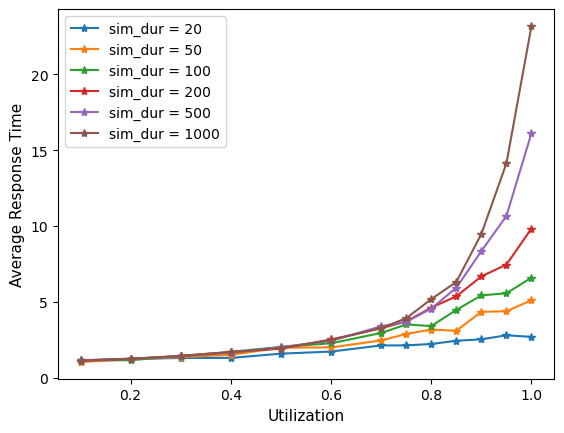

In [49]:
plt.plot(Rho, est_sojourn_20, "*-", label="sim_dur = 20")
plt.plot( Rho, est_sojourn_50, "*-", label="sim_dur = 50")
plt.plot(Rho, est_sojourn_100, "*-", label="sim_dur = 100")
plt.plot(Rho, est_sojourn_200, "*-", label="sim_dur = 200")
plt.plot(Rho, est_sojourn_500, "*-", label="sim_dur = 500")
plt.plot(Rho, est_sojourn_1000, "*-", label="sim_dur = 1000")
plt.legend()
plt.xlabel("Utilization", fontsize=11)
plt.ylabel("Average Response Time", fontsize=11)
plt.savefig("SIM_Duration_vs_Rho_MM1.svg")
plt.savefig("SIM_Duration_vs_Rho_MM1.jpeg")

In [29]:
est_mean_20_2, est_sojourn_20_2 = estimate_waiting_times("MMn", Rho, 2, 20)

In [30]:
est_mean_50_2, est_sojourn_50_2 = estimate_waiting_times("MMn", Rho, 2, 50)

In [31]:
est_mean_100_2, est_sojourn_100_2 = estimate_waiting_times("MMn", Rho, 2, 100)

In [32]:
est_mean_200_2, est_sojourn_200_2 = estimate_waiting_times("MMn", Rho, 2, 200)

In [33]:
est_mean_500_2, est_sojourn_500_2 = estimate_waiting_times("MMn", Rho, 2, 500)

In [34]:
est_mean_1000_2, est_sojourn_1000_2 = estimate_waiting_times("MMn", Rho, 2, 1000)

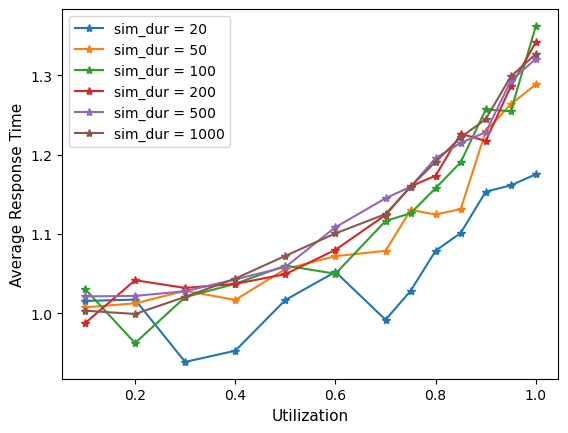

In [50]:
plt.plot(Rho, est_sojourn_20_2, "*-", label="sim_dur = 20")
plt.plot(Rho, est_sojourn_50_2, "*-", label="sim_dur = 50")
plt.plot(Rho, est_sojourn_100_2, "*-", label="sim_dur = 100")
plt.plot(Rho, est_sojourn_200_2, "*-", label="sim_dur = 200")
plt.plot(Rho, est_sojourn_500_2, "*-", label="sim_dur = 500")
plt.plot(Rho, est_sojourn_1000_2, "*-", label="sim_dur = 1000")
plt.legend()
plt.xlabel("Utilization", fontsize=11)
plt.ylabel("Average Response Time", fontsize=11)
plt.savefig("SIM_Duration_vs_Rho_MM2.svg")
plt.savefig("SIM_Duration_vs_Rho_MM2.jpeg")

In [36]:
est_mean_20_4, est_sojourn_20_4 = estimate_waiting_times("MMn", Rho, 4, 20)

In [37]:
est_mean_200_4, est_sojourn_200_4 = estimate_waiting_times("MMn", Rho, 4, 200)

In [38]:
est_mean_500_4, est_sojourn_500_4 = estimate_waiting_times("MMn", Rho, 4, 500)

In [39]:
est_mean_1000_4, est_sojourn_1000_4 = estimate_waiting_times("MMn", Rho, 4, 1000)

In [40]:
est_mean_50_4, est_sojourn_50_4 = estimate_waiting_times("MMn", Rho, 4, 50)

In [41]:
est_mean_100_4, est_sojourn_100_4 = estimate_waiting_times("MMn", Rho, 4, 100)

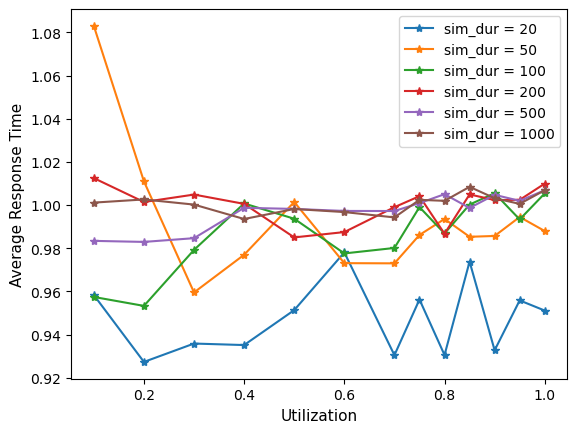

In [51]:
plt.plot(Rho, est_sojourn_20_4, "*-", label="sim_dur = 20")
plt.plot(Rho, est_sojourn_50_4, "*-", label="sim_dur = 50")
plt.plot(Rho, est_sojourn_100_4, "*-", label="sim_dur = 100")
plt.plot(Rho, est_sojourn_200_4, "*-", label="sim_dur = 200")
plt.plot(Rho, est_sojourn_500_4, "*-", label="sim_dur = 500")
plt.plot(Rho, est_sojourn_1000_4, "*-", label="sim_dur = 1000")
plt.legend()
plt.xlabel("Utilization", fontsize=11)
plt.ylabel("Average Response Time", fontsize=11)
plt.savefig("SIM_Duration_vs_Rho_MM4.svg")
plt.savefig("SIM_Duration_vs_Rho_MM4.jpeg")

In [ ]:
def estimate_waiting_times_2(type_queue, RHO, n, runs):
    
    mean_queue = []
    mean_sojourn = []
    temp_queue = []
    temp_sojourn = []
    g.arrival_rate = 1*RHO
    g.service_rate = 1
    g.number_of_servers = n
    g.number_of_runs = runs
    g.sim_duration = 120
    for run in runs :
        for r in range(run):
            queue_model = Queue(r, type_queue)
            queue_model.run()
            temp_queue.append(queue_model.mean_queue_time)
            temp_sojourn.append(queue_model.mean_system_time)
        mean_queue.append(np.array(temp_queue).mean(axis = 0))
        mean_sojourn.append(np.array(temp_sojourn).mean(axis = 0))
    
    return mean_queue, mean_sojourn

In [ ]:
no_runs = list(range(20, 1000, 50))
est_mean_r2, est_sojourn_r2 = estimate_waiting_times_2("MMn", 0.05 , 2, no_runs)
est_mean_r1, est_sojourn_r1 = estimate_waiting_times_2("MMn", 0.05 , 1, no_runs)
est_mean_r4, est_sojourn_r4 = estimate_waiting_times_2("MMn", 0.05, 4, no_runs)

In [ ]:
plt.plot(no_runs, est_sojourn_r20_1, label = "n = 1")
plt.plot(no_runs, est_sojourn_r20_2, label = "n = 2")
plt.plot(no_runs, est_sojourn_r20_4, label = "n = 4")
plt.xlabel("Number of Simulations", fontsize=10)
plt.ylabel("Avg Response Time",fontsize=10)
plt.legend()
plt.legend()

In [ ]:
est_mean_r2_rho2, est_sojourn_r2_rho2 = estimate_waiting_times_2("MMn", 0.1, 2, no_runs)
est_mean_r1_rho2, est_sojourn_r1_rho2 = estimate_waiting_times_2("MMn", 0.1, 1, no_runs)
est_mean_r4_rho2, est_sojourn_r4_rho2 = estimate_waiting_times_2("MMn", 0.1, 4, no_runs)

In [ ]:
plt.plot(no_runs, est_sojourn_r1_rho2, label = "n = 1")
plt.plot(no_runs, est_sojourn_r2_rho2, label = "n = 2")
plt.plot(no_runs, est_sojourn_r4_rho2, label = "n = 4")
plt.xlabel("Number of Simulations", fontsize=10)
plt.ylabel("Avg Response Time",fontsize=10)
plt.legend()
plt.legend()

In [ ]:
est_mean_r2_rho3, est_sojourn_r2_rho3 = estimate_waiting_times_2("MMn", 0.2, 2, no_runs)
est_mean_r1_rho3, est_sojourn_r1_rho3 = estimate_waiting_times_2("MMn", 0.2, 1, no_runs)
est_mean_r4_rho3, est_sojourn_r4_rho3 = estimate_waiting_times_2("MMn", 0.2, 4, no_runs)

In [ ]:
plt.plot(no_runs, est_sojourn_r1_rho3, label = "n = 1")
plt.plot(no_runs, est_sojourn_r2_rho3, label = "n = 2")
plt.plot(no_runs, est_sojourn_r4_rho3, label = "n = 4")
plt.xlabel("Number of Simulations", fontsize=10)
plt.ylabel("Avg Response Time",fontsize=10)
plt.legend()

In [ ]:
est_mean_r2_rho4, est_sojourn_r2_rho4 = estimate_waiting_times_2("MMn", 0.3, 2, no_runs)
est_mean_r1_rho4, est_sojourn_r1_rho4 = estimate_waiting_times_2("MMn", 0.3, 1, no_runs)
est_mean_r4_rho4, est_sojourn_r4_rho4 = estimate_waiting_times_2("MMn", 0.3, 4, no_runs)

In [ ]:
plt.plot(no_runs, est_sojourn_r1_rho4, label = "n = 1")
plt.plot(no_runs, est_sojourn_r2_rho4, label = "n = 2")
plt.plot(no_runs, est_sojourn_r4_rho4, label = "n = 4")
plt.xlabel("Number of Simulations", fontsize=10)
plt.ylabel("Avg Response Time",fontsize=10)
plt.legend()

In [ ]:
est_mean_r2_rho5, est_sojourn_r2_rho5 = estimate_waiting_times_2("MMn", 0.4, 2, no_runs)
est_mean_r1_rho5, est_sojourn_r1_rho5 = estimate_waiting_times_2("MMn", 0.4, 1, no_runs)
est_mean_r4_rho5, est_sojourn_r4_rho5 = estimate_waiting_times_2("MMn", 0.4, 4, no_runs)

In [ ]:
plt.plot(no_runs, est_sojourn_r1_rho5, label = "n = 1")
plt.plot(no_runs, est_sojourn_r2_rho5, label = "n = 2")
plt.plot(no_runs, est_sojourn_r4_rho5, label = "n = 4")
plt.xlabel("Number of Simulations", fontsize=10)
plt.ylabel("Avg Response Time",fontsize=10)
plt.legend()

In [ ]:
est_mean_r2_rho6, est_sojourn_r2_rho6 = estimate_waiting_times_2("MMn", 0.4, 2, no_runs)
est_mean_r1_rho6, est_sojourn_r1_rho6 = estimate_waiting_times_2("MMn", 0.4, 1, no_runs)
est_mean_r4_rho6, est_sojourn_r4_rho6 = estimate_waiting_times_2("MMn", 0.4, 4, no_runs)

In [ ]:
plt.plot(no_runs, est_sojourn_r1_rho6, label = "n = 1")
plt.plot(no_runs, est_sojourn_r2_rho6, label = "n = 2")
plt.plot(no_runs, est_sojourn_r4_rho6, label = "n = 4")
plt.xlabel("Number of Simulations", fontsize=10)
plt.ylabel("Avg Response Time",fontsize=10)
plt.legend()

## Analysis of the customer distribution and occupation rate

In [84]:
TIME_STEPS = np.linspace(0, 200, num=100)
MU = 4

In [85]:
def customer_distribution(type_queue, n, total_time, MU):
    customer_distribution = []
    g.number_of_servers = n
    g.number_of_runs = 200
    g.arrival_rate = MU*0.9
    g.service_rate = MU
    g.sim_duration = 200
    for run in range(g.number_of_runs):
        queue_model = Queue(run, type_queue)
        queue_model.run()
        arrival_times_run = np.array(queue_model.arrival_times)
        departure_times_run = np.array(queue_model.departure_times)
        temp_customer_distribution = []
        unoccupied_queue_list = []
        temp_customer_time_step = 0
        customer_distribution = 0
        unoccupied_queue = 0

        # Per time-step the customers in the system is calculated
        for t_step in range(len(total_time) - 1):
            arrivals_time_step = ((total_time[t_step] <= arrival_times_run) & (arrival_times_run <= total_time[t_step + 1])).sum()
            departures_time_step = ((total_time[t_step] <= departure_times_run) & (departure_times_run <= total_time[t_step + 1])).sum()
            customers_time_step = temp_customer_time_step + (arrivals_time_step - departures_time_step)
            temp_customer_time_step = customers_time_step
            temp_customer_distribution.append(customers_time_step)

            # Keeps track if the queue is empty
            if customers_time_step == 0:
                unoccupied_queue += 1

        customer_distribution += np.array(temp_customer_distribution)
        unoccupied_queue_list.append(unoccupied_queue)

    avg_customer_distribution = customer_distribution / g.number_of_runs
    unoccupied_queue_mean = sum(unoccupied_queue_list)/ len(unoccupied_queue_list)
    occupied_mean = ((200 - (unoccupied_queue_mean * 2)) /200) * 100
    cd = avg_customer_distribution.tolist()
    cd.insert(0,0)
    
    return cd, occupied_mean

In [87]:
cd_1_MMn, occupied_rate_1 = customer_distribution("MMn", 1, TIME_STEPS, MU)
cd_2_MMn, occupied_rate_2 = customer_distribution("MMn", 2, TIME_STEPS, MU)
cd_4_MMn, occupied_rate_4 = customer_distribution("MMn", 4, TIME_STEPS, MU)

88.0


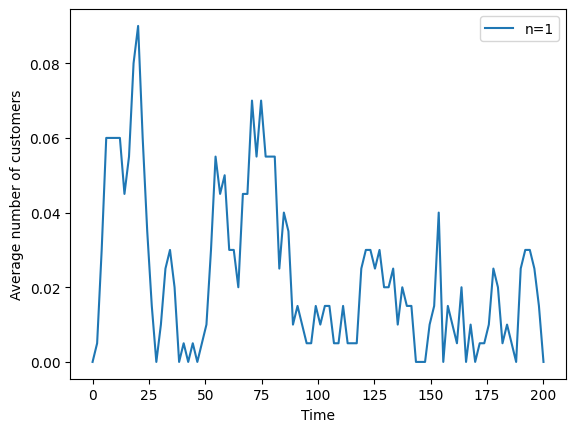

In [105]:
print(occupied_rate_1)
plt.plot(TIME_STEPS, cd_1_MMn, label="n=1")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Average number of customers")
plt.savefig("cd_MMn_n1.svg")

61.0


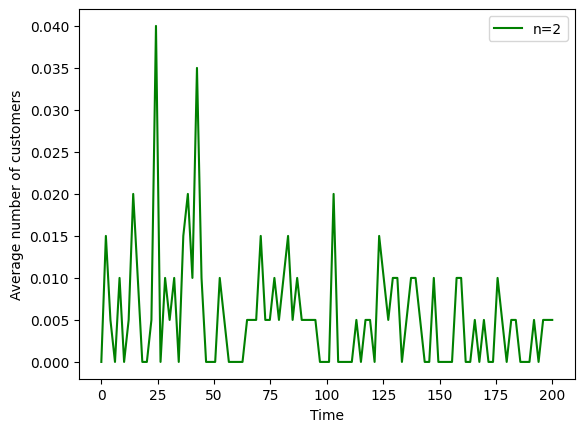

In [106]:
print(occupied_rate_2)
plt.plot(TIME_STEPS, cd_2_MMn, label="n=2", color="green")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Average number of customers")
plt.savefig("cd_MMn_n2.svg")

53.0


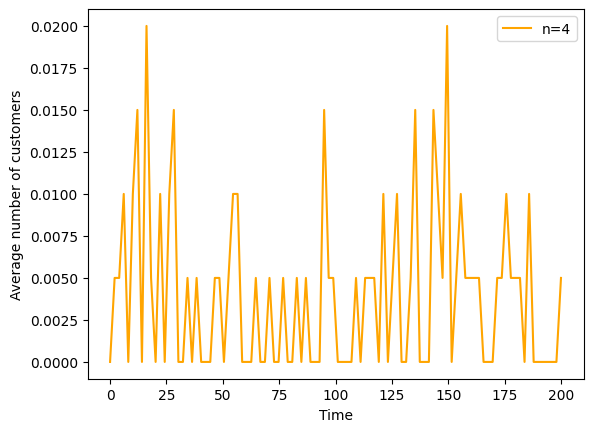

In [107]:
print(occupied_rate_4)
plt.plot(TIME_STEPS, cd_4_MMn, label="n=4", color="orange")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Average number of customers")
plt.savefig("cd_MMn_n4.svg")

In [91]:
cd_1_MDn, occupied_rate_1_MDn = customer_distribution("MDn", 1, TIME_STEPS, MU)
cd_2_MDn, occupied_rate_2_MDn = customer_distribution("MDn", 2, TIME_STEPS, MU)
cd_4_MDn, occupied_rate_4_MDn = customer_distribution("MDn", 4, TIME_STEPS, MU)

100.0


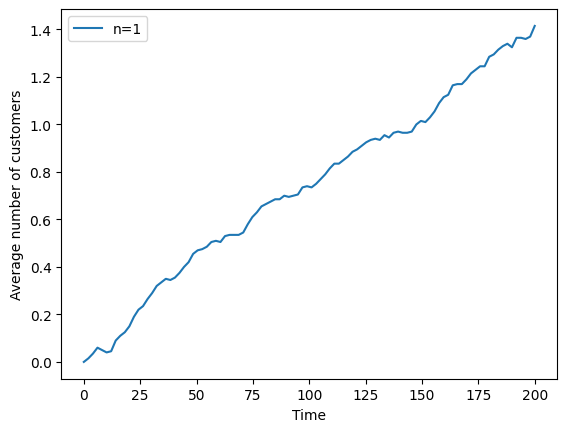

In [108]:
print(occupied_rate_1_MDn)
plt.plot(TIME_STEPS, cd_1_MDn, label="n=1")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Average number of customers")
plt.savefig("cd_MDn_n1.svg")

96.0


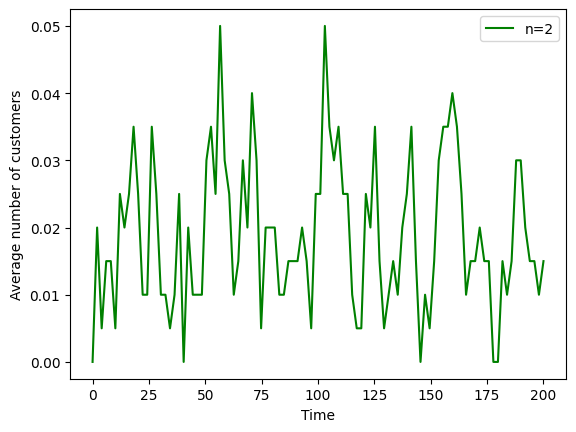

In [109]:
print(occupied_rate_2_MDn)
plt.plot(TIME_STEPS, cd_2_MDn, label="n=2", color="green")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Average number of customers")
plt.savefig("cd_MDn_n2.svg")

85.0


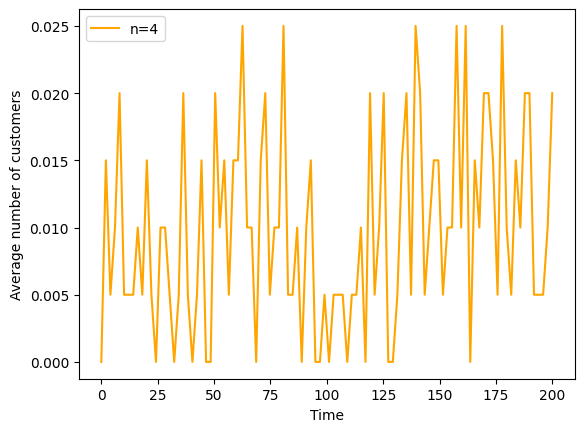

In [110]:
print(occupied_rate_4_MDn)
plt.plot(TIME_STEPS, cd_4_MDn, label="n=4", color="orange")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Average number of customers")
plt.savefig("cd_MDn_n4.svg")

In [95]:
cd_1_MLn, occupied_rate_1_MLn = customer_distribution("MLn", 1, TIME_STEPS, MU)
cd_2_MLn, occupied_rate_2_MLn = customer_distribution("MLn", 2, TIME_STEPS, MU)
cd_4_MLn, occupied_rate_4_MLn = customer_distribution("MLn", 4, TIME_STEPS, MU)

100.0


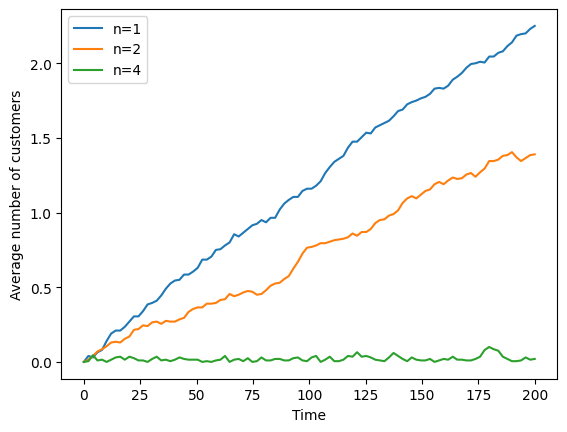

In [111]:
print(occupied_rate_1_MLn)
plt.plot(TIME_STEPS, cd_1_MLn, label="n=1")
plt.plot(TIME_STEPS, cd_2_MLn, label="n=2")
plt.plot(TIME_STEPS, cd_4_MLn, label="n=4")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Average number of customers")
plt.savefig("cd_MLn_alln.svg")

In [100]:
def customer_distribution_SJF(type_queue, n, total_time, MU):
    customer_distribution = []
    g.number_of_servers = n
    g.number_of_runs = 200
    g.arrival_rate = MU*0.9
    g.service_rate = MU

    for run in range(g.number_of_runs):
        queue_model = SJF_queue(run, type_queue)
        queue_model.run()
        arrival_times_run = np.array(queue_model.arrival_times)
        departure_times_run = np.array(queue_model.departure_times)
        temp_customer_distribution = []
        unoccupied_queue_list = []
        temp_customer_time_step = 0
        customer_distribution = 0
        unoccupied_queue = 0

        # Per time-step the customers in the system is calculated
        for t_step in range(len(total_time) - 1):
            arrivals_time_step = ((total_time[t_step] <= arrival_times_run) & (arrival_times_run <= total_time[t_step + 1])).sum()
            departures_time_step = ((total_time[t_step] <= departure_times_run) & (departure_times_run <= total_time[t_step + 1])).sum()
            customers_time_step = temp_customer_time_step + (arrivals_time_step - departures_time_step)
            temp_customer_time_step = customers_time_step
            temp_customer_distribution.append(customers_time_step)

            # Keeps track if the queue is empty
            if customers_time_step == 0:
                unoccupied_queue += 1
            
        customer_distribution += np.array(temp_customer_distribution)
        unoccupied_queue_list.append(unoccupied_queue)


    avg_customer_distribution = customer_distribution / g.number_of_runs
    unoccupied_queue_mean = sum(unoccupied_queue_list)/ len(unoccupied_queue_list)
    occupied_mean = ((200 - (unoccupied_queue_mean * 2)) /200) * 100
    cd = avg_customer_distribution.tolist()
    cd.insert(0,0)

    return cd, occupied_mean

In [103]:
cd_1_MMn_SJF, occupied_rate_1_SJF = customer_distribution_SJF("MMn", 1, TIME_STEPS, MU)

95.0


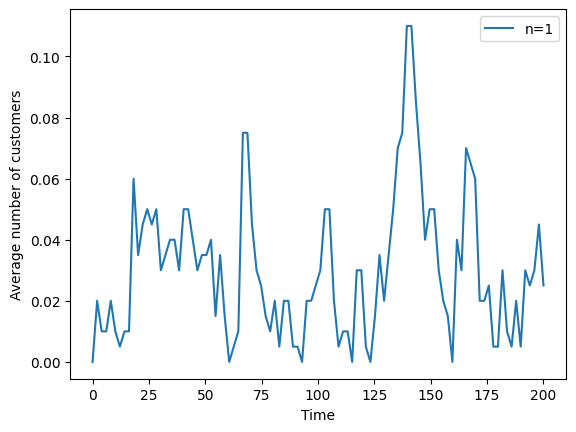

In [112]:
print(occupied_rate_1_SJF)
plt.plot(TIME_STEPS, cd_1_MMn_SJF, label="n=1")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Average number of customers")
plt.savefig("cd_MMn_n1_SJF.svg")